For this first deliverable, I need to develop this:
<br /> 1.- Apply scaling techniques
<br /> 2.- preprocess of data

In [1]:
# Since maybe I'll use my home computer instead of the colab, I'll list the install comands:

# =================================
# PLEASE ONLY RUN ONCE, THEN COMMENT
# THIS SECTION AGAIN.
# =================================

#%pip install numpy
#%pip install pandas
#%pip install tensorflow
#%pip install matplotlib

In [2]:
# All the imports come here
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# It's important to comment the import depending on the OS
# Windows PC
base_dir = r"./dataset/car parts"

# Mac OS
# base_dir = "/Users/alanpagzz/Codes/carssification_AI/dataset/car parts"

# Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# base_dir = "/content/drive/MyDrive/Octavo Semestre/IA/car dataset/car parts"

In [4]:
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")

# I will ommit the test directory for now. I don't want to mix the test data with the training data

In [5]:
# Time to preprocess the data

# SCALING
# First, scale pixels from 0-255 to 0-1
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
valid_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# I don't want to augment the validation data nor the test data

# PREPROCESS
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=8,
    class_mode="categorical",
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=8,
    class_mode="categorical",
)


# Let's get the dictionary
class_indices = train_generator.class_indices
print(class_indices)

Found 6917 images belonging to 40 classes.
Found 200 images belonging to 40 classes.
{'AIR COMPRESSOR': 0, 'ALTERNATOR': 1, 'BATTERY': 2, 'BRAKE CALIPER': 3, 'BRAKE PAD': 4, 'BRAKE ROTOR': 5, 'CAMSHAFT': 6, 'CARBERATOR': 7, 'COIL SPRING': 8, 'CRANKSHAFT': 9, 'CYLINDER HEAD': 10, 'DISTRIBUTOR': 11, 'ENGINE BLOCK': 12, 'FUEL INJECTOR': 13, 'FUSE BOX': 14, 'GAS CAP': 15, 'HEADLIGHTS': 16, 'IDLER ARM': 17, 'IGNITION COIL': 18, 'LEAF SPRING': 19, 'LOWER CONTROL ARM': 20, 'MUFFLER': 21, 'OIL FILTER': 22, 'OIL PAN': 23, 'OVERFLOW TANK': 24, 'OXYGEN SENSOR': 25, 'PISTON': 26, 'RADIATOR': 27, 'RADIATOR FAN': 28, 'RADIATOR HOSE': 29, 'RIM': 30, 'SPARK PLUG': 31, 'STARTER': 32, 'TAILLIGHTS': 33, 'THERMOSTAT': 34, 'TORQUE CONVERTER': 35, 'TRANSMISSION': 36, 'VACUUM BRAKE BOOSTER': 37, 'VALVE LIFTER': 38, 'WATER PUMP': 39}


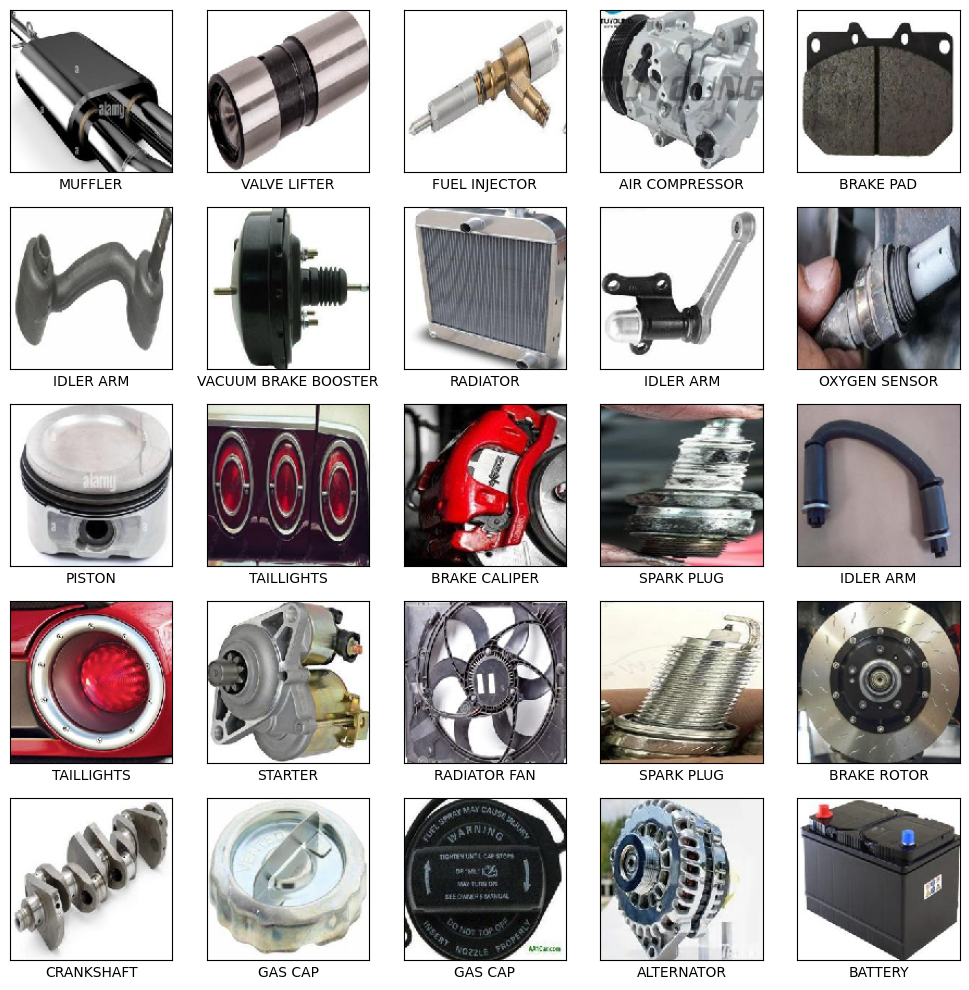

In [6]:
# Just to check if the data is loading correctly
# Let's visualize some images from the training set

# get class from index, from the dictionary
index_to_class = {i: j for j, i in train_generator.class_indices.items()}

plt.figure(figsize=(10, 10))

# Let's show 25 images
for i in range(25):
    img, label = next(train_generator) 
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[0])
    class_index = np.argmax(label[0])
    plt.xlabel(index_to_class[class_index])
plt.tight_layout()
plt.show()